In [1]:
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import torch
from environment3 import LifeStyleEnv
from stable_baselines3 import DQN

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def make_env(is_eval: bool = False):
    env = LifeStyleEnv()
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True) 
    return env

env = make_env()

eval_env = make_env(is_eval=True)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/dqn/dqn_best_model",
    log_path="./logs/dqn/dqn_results",
    eval_freq=5000,
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

model = DQN(
    "MultiInputPolicy",  
    env,
    learning_rate=0.0005,
    batch_size=128,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1, 
    target_update_interval=1000,
    exploration_fraction=0.3,
    verbose=1,
    device=device,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log="./logs/dqn/dqn_tensorboard/"
)

model.learn(
    total_timesteps=200000, 
    callback=eval_callback
)


2025-09-03 15:22:47.389424: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 15:22:47.418922: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 15:22:48.391386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 

Using device: cuda
Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/dqn/dqn_tensorboard/DQN_5
Eval num_timesteps=5000, episode_reward=-7345.89 +/- 0.15
Episode length: 1368.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 1.37e+03  |
|    mean_reward      | -7.35e+03 |
| rollout/            |           |
|    exploration_rate | 0.921     |
| time/               |           |
|    total_timesteps  | 5000      |
| train/              |           |
|    learning_rate    | 0.0005    |
|    loss             | 8.8       |
|    n_updates        | 1224      |
-----------------------------------
New best mean reward!
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 2.2e+03   |
|    ep_rew_mean      | -8.37e+03 |
|    exploration_rate | 0.861     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 427       |
|    time_elaps

In [2]:
from environment3 import LifeStyleEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import numpy as np
from stable_baselines3 import DQN

def make_env(is_eval: bool = False):
    env = LifeStyleEnv(days_per_episode = 365)
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True)
    return env

eval_env = make_env(is_eval=True)

model = DQN.load("logs/dqn/dqn_best_model/best_model.zip")

print("Starting Final Evaluation...")
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"| {'Day':<3} | {'Timeslot':<10} | {'Action':<10} | {'Event':<10} | {'BMI':<8} | {'Stress':<8} | {'Energy':<8} | {'Hunger':<8} | {'Cal. Intake':<12} | {'Cal. Burned':<12} | {'Reward':<8} |")
print("-------------------------------------------------------------------------------------------------------------------------------------")

episode_rewards = []
for episode in range(1):  
    obs, info = eval_env.reset()
    unwrapped_env = eval_env.unwrapped
    
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        total_reward += reward
        
        timeslot_applied = unwrapped_env.state['current_timeslot'] - 1
        timeslot_applied = max(timeslot_applied, 0)  
        event_applied = unwrapped_env.daily_schedule[timeslot_applied]

        print(
            f"| {unwrapped_env.state['day_of_episode']:<3} | "
            f"{unwrapped_env.state['current_timeslot']:<10} | "
            f"{action:<10} | "
            f"{event_applied:<10} | "
            f"{unwrapped_env.state['current_bmi']:<8.2f} | "
            f"{unwrapped_env.state['current_stress_level']:<8.2f} | "
            f"{unwrapped_env.state['current_energy_level']:<8.2f} | "
            f"{unwrapped_env.state['current_hunger_level']:<8.2f} | "
            f"{unwrapped_env.state['daily_calories_intake']:<12.2f} | "
            f"{unwrapped_env.state['daily_calories_burned']:<12.2f} | "
            f"{reward:<8.2f} |"
        )
        
        episode_rewards.append(reward)

print("-------------------------------------------------------------------------------------------------------------------------------------")
print("Mean evaluation reward:", np.mean(episode_rewards))
print("Std deviation:", np.std(episode_rewards))

Starting Final Evaluation...
-------------------------------------------------------------------------------------------------------------------------------------
| Day | Timeslot   | Action     | Event      | BMI      | Stress   | Energy   | Hunger   | Cal. Intake  | Cal. Burned  | Reward   |
-------------------------------------------------------------------------------------------------------------------------------------
| 0   | 1          | 8          | sleep      | 24.22    | 46.00    | 54.00    | 48.00    | 0.00         | 66.15        | 1.11     |
| 0   | 2          | 8          | sleep      | 24.22    | 42.00    | 58.00    | 46.00    | 0.00         | 132.30       | 2.41     |
| 0   | 3          | 8          | sleep      | 24.22    | 38.00    | 62.00    | 44.00    | 0.00         | 198.45       | 3.69     |
| 0   | 4          | 8          | sleep      | 24.22    | 34.00    | 66.00    | 42.00    | 0.00         | 264.60       | 4.95     |
| 0   | 5          | 8          | sleep    

## Test underweight scenarios

In [4]:
from environment3 import LifeStyleEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import numpy as np
from stable_baselines3 import DQN

def make_env(is_eval: bool = False):
    env = LifeStyleEnv(days_per_episode = 365, initial_weight_kg=85)
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True)
    return env

eval_env = make_env(is_eval=True)

model = DQN.load("logs/dqn/dqn_best_model/best_model.zip")

print("Starting Final Evaluation...")
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"| {'Day':<3} | {'Timeslot':<10} | {'Action':<10} | {'Event':<10} | {'BMI':<8} | {'Stress':<8} | {'Energy':<8} | {'Hunger':<8} | {'Cal. Intake':<12} | {'Cal. Burned':<12} | {'Reward':<8} |")
print("-------------------------------------------------------------------------------------------------------------------------------------")

episode_rewards = []
for episode in range(1):  
    obs, info = eval_env.reset()
    unwrapped_env = eval_env.unwrapped
    
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        total_reward += reward
        
        timeslot_applied = unwrapped_env.state['current_timeslot'] - 1
        timeslot_applied = max(timeslot_applied, 0)  
        event_applied = unwrapped_env.daily_schedule[timeslot_applied]

        print(
            f"| {unwrapped_env.state['day_of_episode']:<3} | "
            f"{unwrapped_env.state['current_timeslot']:<10} | "
            f"{action:<10} | "
            f"{event_applied:<10} | "
            f"{unwrapped_env.state['current_bmi']:<8.2f} | "
            f"{unwrapped_env.state['current_stress_level']:<8.2f} | "
            f"{unwrapped_env.state['current_energy_level']:<8.2f} | "
            f"{unwrapped_env.state['current_hunger_level']:<8.2f} | "
            f"{unwrapped_env.state['daily_calories_intake']:<12.2f} | "
            f"{unwrapped_env.state['daily_calories_burned']:<12.2f} | "
            f"{reward:<8.2f} |"
        )
        
        episode_rewards.append(reward)

print("-------------------------------------------------------------------------------------------------------------------------------------")
print("Mean evaluation reward:", np.mean(episode_rewards))
print("Std deviation:", np.std(episode_rewards))

Starting Final Evaluation...
-------------------------------------------------------------------------------------------------------------------------------------
| Day | Timeslot   | Action     | Event      | BMI      | Stress   | Energy   | Hunger   | Cal. Intake  | Cal. Burned  | Reward   |
-------------------------------------------------------------------------------------------------------------------------------------
| 0   | 1          | 8          | sleep      | 29.41    | 46.00    | 54.00    | 48.00    | 0.00         | 80.33        | 1.17     |
| 0   | 2          | 8          | sleep      | 29.41    | 42.00    | 58.00    | 46.00    | 0.00         | 160.65       | 2.54     |
| 0   | 3          | 8          | sleep      | 29.41    | 38.00    | 62.00    | 44.00    | 0.00         | 240.98       | 3.88     |
| 0   | 4          | 8          | sleep      | 29.41    | 34.00    | 66.00    | 42.00    | 0.00         | 321.30       | 5.21     |
| 0   | 5          | 8          | sleep    

Contents of the NPZ file: ['timesteps', 'results', 'ep_lengths']


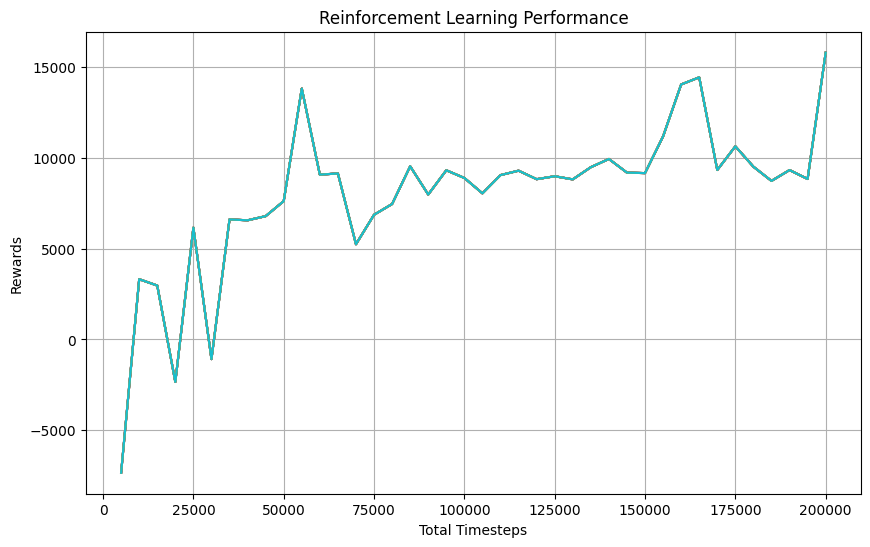

In [2]:
import numpy as np
import matplotlib.pyplot as plt

file_path = 'logs/dqn/dqn_results/evaluations.npz'

try:
    data = np.load(file_path)
    print(f"Contents of the NPZ file: {data.files}")
    timesteps = data['timesteps']
    results = data['results']

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, results)

    plt.title('Reinforcement Learning Performance')
    plt.xlabel('Total Timesteps')
    plt.ylabel('Rewards')
    plt.grid(True)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except KeyError as e:
    print(f"Error: The key {e} was not found in the NPZ file. Check the contents using data.files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")